# Data Cleaning and Preprocessing


In [1]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from fitter import Fitter, get_common_distributions
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import warnings

warnings.filterwarnings("ignore")

pd.set_option("future.no_silent_downcasting", True)

In [2]:
orders_df = pd.read_csv("orders_data_competition.csv")

In [3]:
clients_df = pd.read_csv("clients_data_competition.csv")

## Orders Data


In [4]:
orders_df.dropna(inplace=True)

In [5]:
agg_orders = pd.DataFrame()

In [6]:
# Add an AccountID column to the aggregate orders df
agg_orders["AccountID"] = clients_df["Account ID"].unique()

In [7]:
# Add a NumOfOrders column that has the number of orders for each account
agg_orders["NumOfOrders"] = orders_df.groupby("Account ID").size()

# Set the number of orders for the accounts that didn't place any order to 0
agg_orders["NumOfOrders"] = agg_orders["NumOfOrders"].fillna(0)

# Convert the type to int
agg_orders["NumOfOrders"] = agg_orders["NumOfOrders"].astype(int)

In [8]:
# Convert the 'order_date' column to datetime
orders_df["Order Time"] = pd.to_datetime(orders_df["Order Time"])

# Create a new dataframe with the last order date for each account
agg_orders["LastOrder"] = orders_df.groupby("Account ID")["Order Time"].max()


# Convert the LastOrder column to datetime
agg_orders["LastOrder"] = pd.to_datetime(agg_orders["LastOrder"], format="%d-%m-%Y")

# Create the Month and Year columns
agg_orders["LastOrder_Month"] = agg_orders["LastOrder"].dt.month
agg_orders["LastOrder_Year"] = agg_orders["LastOrder"].dt.year

# Set the month for the accounts that didn't place any order to 0
agg_orders["LastOrder_Month"] = agg_orders["LastOrder_Month"].fillna(0)

# Set the year for the accounts that didn't place any order to 0
agg_orders["LastOrder_Year"] = agg_orders["LastOrder_Year"].fillna(0)

# Convert the type to int
agg_orders["LastOrder_Month"] = agg_orders["LastOrder_Month"].astype(int)
agg_orders["LastOrder_Year"] = agg_orders["LastOrder_Year"].astype(int)

# One-hot-encode the Month and the Year columns
agg_orders = pd.get_dummies(
    agg_orders, columns=["LastOrder_Month", "LastOrder_Year"], dtype=int
)

# Drop the unnecessary columns
agg_orders.drop(
    columns=["LastOrder", "LastOrder_Month_0", "LastOrder_Year_0"], inplace=True
)

In [9]:
# Add a NumOfCompleted column that has the number of completed orders for each account
agg_orders["NumOfCompleted"] = orders_df.groupby("Account ID")["Is Completed"].sum()

# Set the number of completed orders for the accounts that didn't place any order to 0
agg_orders["NumOfCompleted"] = agg_orders["NumOfCompleted"].fillna(0)

# # Convert the type to int
agg_orders["NumOfCompleted"] = agg_orders["NumOfCompleted"].astype(int)

In [10]:
# Add a NumOfCanceled column that has the number of completed orders for each account
agg_orders["NumOfCanceled"] = orders_df.groupby("Account ID")["Is Canceled"].sum()

# Set the number of completed orders for the accounts that didn't place any order to 0
agg_orders["NumOfCanceled"] = agg_orders["NumOfCanceled"].fillna(0)

# # Convert the type to int
agg_orders["NumOfCanceled"] = agg_orders["NumOfCanceled"].astype(int)

In [11]:
# Add a AvgPrice column that has the number of completed orders for each account
agg_orders["AvgPrice"] = (
    orders_df.groupby("Account ID")["Price"].sum()
    / orders_df.groupby("Account ID").size()
)

# Set the number of completed orders for the accounts that didn't place any order to 0
agg_orders["AvgPrice"] = agg_orders["AvgPrice"].fillna(0.0)

In [12]:
# Add a TotalExecutedQuantity column that has the number of completed orders for each account
agg_orders["TotalExecutedQuantity"] = orders_df.groupby("Account ID")[
    "Executed Quantity"
].sum()

# Set the number of completed orders for the accounts that didn't place any order to 0
agg_orders["TotalExecutedQuantity"] = agg_orders["TotalExecutedQuantity"].fillna(0)

# # Convert the type to int
agg_orders["TotalExecutedQuantity"] = agg_orders["TotalExecutedQuantity"].astype(int)

In [13]:
# Add a TotalQuantity column that has the number of completed orders for each account
agg_orders["TotalQuantity"] = orders_df.groupby("Account ID")["Quantity"].sum()

# Set the number of completed orders for the accounts that didn't place any order to 0
agg_orders["TotalQuantity"] = agg_orders["TotalQuantity"].fillna(0)

# # Convert the type to int
agg_orders["TotalQuantity"] = agg_orders["TotalQuantity"].astype(int)

In [14]:
def calculating_IDF(df):
    idf = {}
    for i in df.columns:
        idf[i] = (
            np.log2(df.shape[0] / df[df[i] > 0].shape[0])
            if df[df[i] > 0].shape[0] != 0
            else 1e-6
        )
    return idf

In [15]:
def calculate_TFIDF(df, idf_dict):
    tfidf_df = df.copy()
    for i in df.columns:
        tfidf_df[i] = df[i] * idf_dict[i]
    return tfidf_df

In [16]:
def TFIDF(column_name: str):
    temp = pd.get_dummies(orders_df, columns=[column_name])
    temp.replace({True: 1, False: 0}, inplace=True)

    tfidf_df = pd.DataFrame(data=agg_orders.iloc[:, 0])

    for word in orders_df[column_name].unique():
        col_name = f"{column_name}_{word}"

        tfidf_df[col_name.replace(" ", "")] = temp.groupby("Account ID")[col_name].sum()

        tfidf_df[col_name.replace(" ", "")] = tfidf_df[
            col_name.replace(" ", "")
        ].fillna(0)

        tfidf_df[col_name.replace(" ", "")] = tfidf_df[
            col_name.replace(" ", "")
        ].astype(int)

    idf_dict = calculating_IDF(tfidf_df.iloc[:, 1:])
    tfidf_df = calculate_TFIDF(tfidf_df.iloc[:, 1:], idf_dict)
    return pd.concat([agg_orders, tfidf_df], axis=1)

In [17]:
agg_orders = TFIDF("Order Type")

In [18]:
agg_orders = TFIDF("Security ID")

In [19]:
agg_orders = TFIDF("Order Via")

In [20]:
agg_orders = TFIDF("Execution Status")

In [21]:
agg_orders = TFIDF("Sector Name")

In [22]:
agg_orders.head()

,AccountID,NumOfOrders,LastOrder_Month_1,LastOrder_Month_2,LastOrder_Month_3,LastOrder_Month_4,LastOrder_Month_5,LastOrder_Month_6,LastOrder_Month_7,LastOrder_Month_8,...,SectorName_TelecommunicationServices,SectorName_REALESTATE,SectorName_Telecommunications,SectorName_FOOD,SectorName_Others,SectorName_Tourism,SectorName_ConsumerServices,SectorName_Utilities,SectorName_Trade,SectorName_PharmaceuticalIndustries
0,0,2,0,0,0,0,0,0,0,0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,1,7,0,0,0,0,0,0,0,0,...,0.000000,0.0,0.0,2.797573,0.0,0.0,0.0,0.0,0.0,0.0
2,2,21,0,1,0,0,0,0,0,0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,3,88,0,0,1,0,0,0,0,0,...,6.297068,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,4,30,0,1,0,0,0,0,0,0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
agg_orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13523 entries, 0 to 13522
Columns: 389 entries, AccountID to SectorName_PharmaceuticalIndustries
dtypes: float64(368), int64(21)
memory usage: 40.1 MB


In [24]:
def get_normalized_data(data, dist):
    if dist == "uniform":
        return MinMaxScaler().fit_transform(data)
    elif dist == "norm":
        return StandardScaler().fit_transform(data)
    elif dist == "lognorm" or dist == "expon":
        return np.log(np.abs(data.flatten()) + 1)

In [25]:
def get_best_distribution():
    columns = [
        "NumOfCompleted",
        "NumOfCanceled",
        "AvgPrice",
        "TotalExecutedQuantity",
        "NumOfOrders",
        "TotalQuantity",
    ]

    columns_distributions_dict = {column: "" for column in columns}

    for column in columns:
        print("###### " + column + " ######")

        data = agg_orders[column].values

        f = Fitter(
            data,
            distributions=get_common_distributions(),
        )
        f.fit()
        f.summary(plot=False)
        dist = f.get_best(method="sumsquare_error")
        best_dist = ""
        for key in dist.keys():
            best_dist = key

        columns_distributions_dict[column] = str(best_dist)
        print(column)
        print(f"Best Distribution: {best_dist}")
        print()

    return columns_distributions_dict

In [26]:
def normalize():
    columns_distributions_dict = get_best_distribution()

    for column in columns_distributions_dict.keys():
        data = np.array(agg_orders[column]).reshape(-1, 1)
        agg_orders[column] = get_normalized_data(
            data=data, dist=columns_distributions_dict[column]
        )
    return columns_distributions_dict

In [27]:
print(normalize())

2024-04-15 02:07:16.005 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted expon distribution with error=2.4e-05)
2024-04-15 02:07:16.013 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted norm distribution with error=0.000123)
2024-04-15 02:07:16.063 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted uniform distribution with error=0.00015)
2024-04-15 02:07:16.090 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted rayleigh distribution with error=0.000114)


###### NumOfCompleted ######


2024-04-15 02:07:16.172 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted cauchy distribution with error=0.000117)
2024-04-15 02:07:16.694 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted gamma distribution with error=0.000152)
2024-04-15 02:07:16.749 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted chi2 distribution with error=9.3e-05)
2024-04-15 02:07:16.779 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted powerlaw distribution with error=0.000149)
2024-04-15 02:07:16.820 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted exponpow distribution with error=8.4e-05)
2024-04-15 02:07:16.862 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted lognorm distribution with error=0.000151)
2024-04-15 02:07:16.911 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted norm distribution with error=0.000405)
2024-04-15 02:07:16.914 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted exp

NumOfCompleted
Best Distribution: expon

###### NumOfCanceled ######


2024-04-15 02:07:17.526 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted gamma distribution with error=0.000531)
2024-04-15 02:07:17.566 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted chi2 distribution with error=0.000302)
2024-04-15 02:07:17.601 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted powerlaw distribution with error=0.000524)
2024-04-15 02:07:17.634 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted exponpow distribution with error=0.000295)
2024-04-15 02:07:17.683 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted lognorm distribution with error=0.000529)
2024-04-15 02:07:17.724 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted expon distribution with error=3.4e-05)
2024-04-15 02:07:17.732 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted norm distribution with error=0.000916)
2024-04-15 02:07:17.754 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted uni

NumOfCanceled
Best Distribution: expon

###### AvgPrice ######


2024-04-15 02:07:18.343 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted gamma distribution with error=0.001539)
2024-04-15 02:07:18.397 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted powerlaw distribution with error=0.001501)
2024-04-15 02:07:18.398 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted chi2 distribution with error=0.000597)
2024-04-15 02:07:18.447 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted exponpow distribution with error=0.000729)
2024-04-15 02:07:18.486 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted lognorm distribution with error=0.001531)
2024-04-15 02:07:18.522 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted norm distribution with error=0.0)
2024-04-15 02:07:18.540 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted expon distribution with error=0.0)
2024-04-15 02:07:18.560 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted uniform dist

AvgPrice
Best Distribution: expon

###### TotalExecutedQuantity ######


2024-04-15 02:07:18.779 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted cauchy distribution with error=0.0)
2024-04-15 02:07:18.880 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted gamma distribution with error=0.0)
2024-04-15 02:07:19.184 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted chi2 distribution with error=0.0)
2024-04-15 02:07:19.213 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted powerlaw distribution with error=0.0)
2024-04-15 02:07:19.251 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted exponpow distribution with error=0.0)
2024-04-15 02:07:19.291 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted lognorm distribution with error=0.0)
2024-04-15 02:07:19.330 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted norm distribution with error=3.7e-05)
2024-04-15 02:07:19.341 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted expon distribution with error=7e

TotalExecutedQuantity
Best Distribution: expon

###### NumOfOrders ######


2024-04-15 02:07:20.067 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted gamma distribution with error=4.6e-05)
2024-04-15 02:07:20.125 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted chi2 distribution with error=2.8e-05)
2024-04-15 02:07:20.160 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted powerlaw distribution with error=4.5e-05)
2024-04-15 02:07:20.256 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted exponpow distribution with error=3.2e-05)
2024-04-15 02:07:20.307 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted lognorm distribution with error=4.6e-05)
2024-04-15 02:07:20.395 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted expon distribution with error=0.0)
2024-04-15 02:07:20.403 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted norm distribution with error=0.0)
2024-04-15 02:07:20.428 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted uniform distribut

NumOfOrders
Best Distribution: expon

###### TotalQuantity ######


2024-04-15 02:07:20.656 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted gamma distribution with error=0.0)
2024-04-15 02:07:20.686 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted cauchy distribution with error=0.0)
2024-04-15 02:07:21.098 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted chi2 distribution with error=0.0)
2024-04-15 02:07:21.154 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted powerlaw distribution with error=0.0)
2024-04-15 02:07:21.197 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted exponpow distribution with error=0.0)
2024-04-15 02:07:21.247 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted lognorm distribution with error=0.0)


TotalQuantity
Best Distribution: expon

{'NumOfCompleted': 'expon', 'NumOfCanceled': 'expon', 'AvgPrice': 'expon', 'TotalExecutedQuantity': 'expon', 'NumOfOrders': 'expon', 'TotalQuantity': 'expon'}


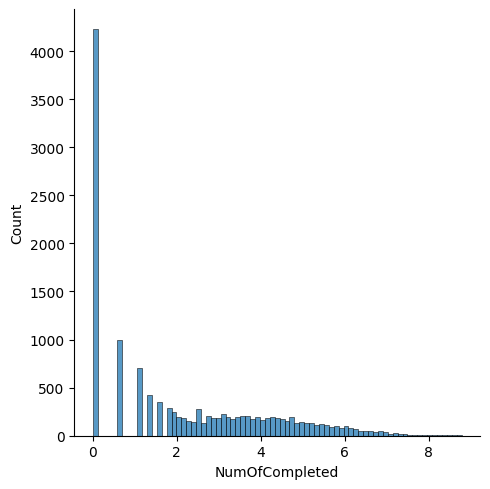

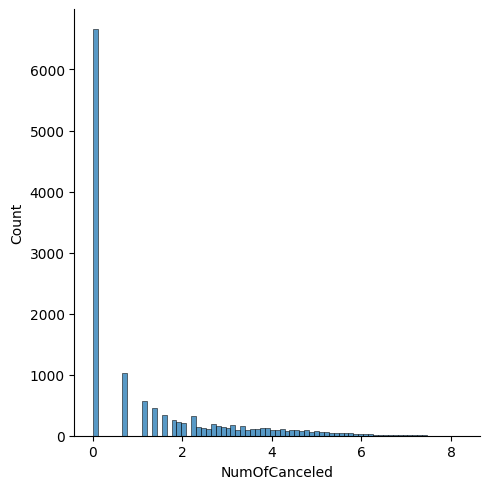

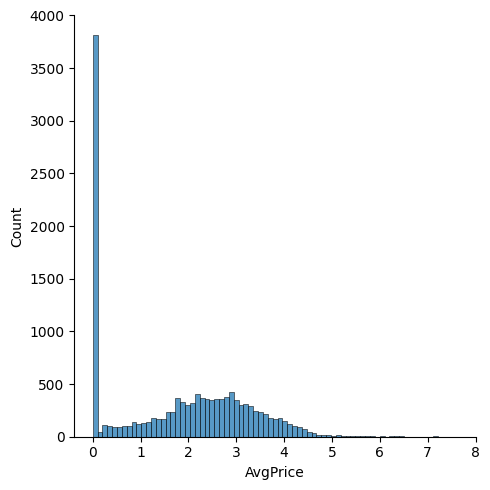

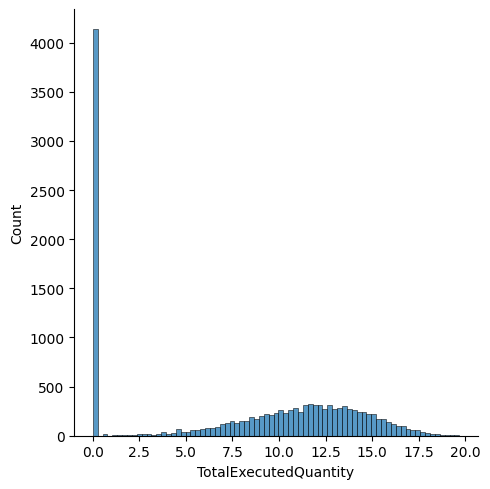

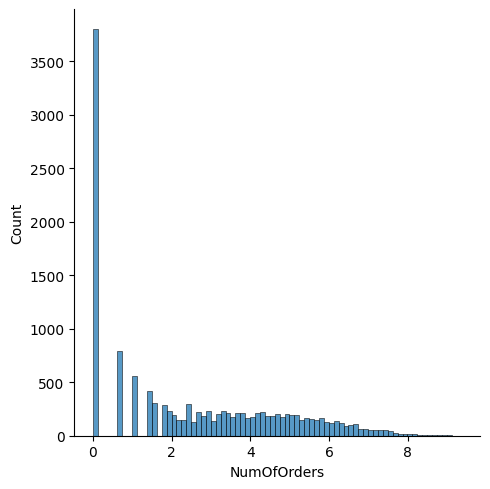

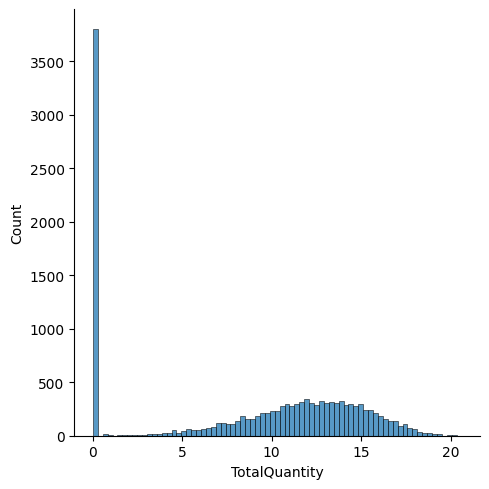

In [28]:
columns = [
    "NumOfCompleted",
    "NumOfCanceled",
    "AvgPrice",
    "TotalExecutedQuantity",
    "NumOfOrders",
    "TotalQuantity",
]
for column in columns:
    sns.displot(data=agg_orders[columns], x=column, bins=75)

In [29]:
agg_orders.head()

,AccountID,NumOfOrders,LastOrder_Month_1,LastOrder_Month_2,LastOrder_Month_3,LastOrder_Month_4,LastOrder_Month_5,LastOrder_Month_6,LastOrder_Month_7,LastOrder_Month_8,...,SectorName_TelecommunicationServices,SectorName_REALESTATE,SectorName_Telecommunications,SectorName_FOOD,SectorName_Others,SectorName_Tourism,SectorName_ConsumerServices,SectorName_Utilities,SectorName_Trade,SectorName_PharmaceuticalIndustries
0,0,1.098612,0,0,0,0,0,0,0,0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,1,2.079442,0,0,0,0,0,0,0,0,...,0.000000,0.0,0.0,2.797573,0.0,0.0,0.0,0.0,0.0,0.0
2,2,3.091042,0,1,0,0,0,0,0,0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,3,4.488636,0,0,1,0,0,0,0,0,...,6.297068,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,4,3.433987,0,1,0,0,0,0,0,0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


In [30]:
agg_orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13523 entries, 0 to 13522
Columns: 389 entries, AccountID to SectorName_PharmaceuticalIndustries
dtypes: float64(373), int64(16)
memory usage: 40.1 MB


## Clients Data


In [31]:
clients_df.head()

,Client ID,Account ID,Gender,Risk Rate,Company Name,Is Closed,Is Dormant,Is Profile Suspended,Is Client Suspended,Client Type Name,OpenDate,BirthDate
0,0,0,Male,Low,HSB,0,0.0,0,0,Individuals,2/16/2014,1990-07-27
1,1,1,Female,Low,HSB,0,-1.0,1,0,Individuals,2/16/2014,1963-10-22
2,2,2,Male,Low,HSB,0,0.0,0,0,Individuals,2/17/2014,1971-05-14
3,3,3,Male,Low,HSB,0,0.0,0,0,Individuals,2/17/2014,1953-01-14
4,4,4,Male,Low,HSB,0,0.0,0,0,Individuals,2/17/2014,1976-06-09


In [32]:
clients_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13523 entries, 0 to 13522
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Client ID             13523 non-null  int64  
 1   Account ID            13523 non-null  int64  
 2   Gender                13523 non-null  object 
 3   Risk Rate             13523 non-null  object 
 4   Company Name          13523 non-null  object 
 5   Is Closed             13523 non-null  int64  
 6   Is Dormant            13523 non-null  float64
 7   Is Profile Suspended  13523 non-null  int64  
 8   Is Client Suspended   13523 non-null  int64  
 9   Client Type Name      13523 non-null  object 
 10  OpenDate              13523 non-null  object 
 11  BirthDate             13523 non-null  object 
dtypes: float64(1), int64(5), object(6)
memory usage: 1.2+ MB


In [33]:
clients_df.dropna(inplace=True)

In [34]:
clients_df["Is Dormant"] = clients_df["Is Dormant"].astype(int) * -1

In [35]:
# Convert the OpenDate column to datetime
clients_df["OpenDate"] = pd.to_datetime(clients_df["OpenDate"], format="%m/%d/%Y")

# Create the Month and Year columns
clients_df["OpenDate_Month"] = clients_df["OpenDate"].dt.month
clients_df["OpenDate_Year"] = clients_df["OpenDate"].dt.year

# Convert the type to int
clients_df["OpenDate_Month"] = clients_df["OpenDate_Month"].astype(int)
clients_df["OpenDate_Year"] = clients_df["OpenDate_Year"].astype(int)

# One-hot-encode the Month and the Year columns
clients_df = pd.get_dummies(
    clients_df, columns=["OpenDate_Month", "OpenDate_Year"], dtype=int
)

# Drop the unnecessary columns
clients_df.drop(columns=["OpenDate"], inplace=True)

In [36]:
# Convert the BirthDate column to datetime
clients_df["BirthDate"] = pd.to_datetime(clients_df["BirthDate"], format="%Y-%m-%d")

# Create the Month and Year columns
clients_df["BirthDate_Month"] = clients_df["BirthDate"].dt.month
clients_df["BirthDate_Year"] = clients_df["BirthDate"].dt.year

# Convert the type to int
clients_df["BirthDate_Month"] = clients_df["BirthDate_Month"].astype(int)
clients_df["BirthDate_Year"] = clients_df["BirthDate_Year"].astype(int)

# One-hot-encode the Month and the Year columns
clients_df = pd.get_dummies(
    clients_df, columns=["BirthDate_Month", "BirthDate_Year"], dtype=int
)

# Drop the unnecessary columns
clients_df.drop(columns=["BirthDate"], inplace=True)

In [37]:
clients_df = pd.get_dummies(
    clients_df, columns=["Gender", "Risk Rate", "Client Type Name"], dtype=int
)

In [38]:
clients_df.drop(columns=["Company Name"], inplace=True)

In [39]:
clients_df.rename(columns=lambda x: x.replace(" ", ""), inplace=True)

In [40]:
clients_df.head()

,ClientID,AccountID,IsClosed,IsDormant,IsProfileSuspended,IsClientSuspended,OpenDate_Month_1,OpenDate_Month_2,OpenDate_Month_3,OpenDate_Month_4,...,BirthDate_Year_2005,BirthDate_Year_2006,Gender_Female,Gender_Male,RiskRate_High,RiskRate_Low,RiskRate_Medium,RiskRate_NotAssigned,ClientTypeName_Companies,ClientTypeName_Individuals
0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,1,0,1,0,0,0,1
1,1,1,0,1,1,0,0,1,0,0,...,0,0,1,0,0,1,0,0,0,1
2,2,2,0,0,0,0,0,1,0,0,...,0,0,0,1,0,1,0,0,0,1
3,3,3,0,0,0,0,0,1,0,0,...,0,0,0,1,0,1,0,0,0,1
4,4,4,0,0,0,0,0,1,0,0,...,0,0,0,1,0,1,0,0,0,1


In [41]:
clients_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13523 entries, 0 to 13522
Columns: 124 entries, ClientID to ClientTypeName_Individuals
dtypes: int64(124)
memory usage: 12.8 MB


## Merging


In [42]:
df = pd.merge(clients_df, agg_orders, on="AccountID", how="inner")

In [43]:
df.head()

,ClientID,AccountID,IsClosed,IsDormant,IsProfileSuspended,IsClientSuspended,OpenDate_Month_1,OpenDate_Month_2,OpenDate_Month_3,OpenDate_Month_4,...,SectorName_TelecommunicationServices,SectorName_REALESTATE,SectorName_Telecommunications,SectorName_FOOD,SectorName_Others,SectorName_Tourism,SectorName_ConsumerServices,SectorName_Utilities,SectorName_Trade,SectorName_PharmaceuticalIndustries
0,0,0,0,0,0,0,0,1,0,0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,1,1,0,1,1,0,0,1,0,0,...,0.000000,0.0,0.0,2.797573,0.0,0.0,0.0,0.0,0.0,0.0
2,2,2,0,0,0,0,0,1,0,0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,3,3,0,0,0,0,0,1,0,0,...,6.297068,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,4,4,0,0,0,0,0,1,0,0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13523 entries, 0 to 13522
Columns: 512 entries, ClientID to SectorName_PharmaceuticalIndustries
dtypes: float64(373), int64(139)
memory usage: 52.8 MB


## Defining The Label


In [45]:
# Compute the ratio of TotalExecutedQuantity/TotalQuantity
df["ExecutedQuantityRatio"] = df.apply(
    lambda row: (
        1
        if row["TotalQuantity"] == 0
        else row["TotalExecutedQuantity"] / row["TotalQuantity"]
    ),
    axis=1,
)

df["Churned"] = (
    # Churned if no order for a long time and account is dormant
    (df["IsDormant"] == 1)
    |
    # Churned if high risk rate and low executed quantity ratio
    (df["RiskRate_High"] == 1) & (df["ExecutedQuantityRatio"] < 0.5)
    |
    # Churned if account is closed
    (df["IsClosed"] == 1)
    |
    # Churned if client is suspended
    (df["IsClientSuspended"] == 1)
    | (df["IsProfileSuspended"] == 1)
)

df = df.replace({True: 1, False: 0})

df["Churned"] = df["Churned"].astype(int)

In [46]:
df.drop(
    columns=[
        "ExecutedQuantityRatio",
        "IsDormant",
        "RiskRate_High",
        "IsClosed",
        "IsClientSuspended",
    ],
    inplace=True,
)

In [47]:
df.head()

,ClientID,AccountID,IsProfileSuspended,OpenDate_Month_1,OpenDate_Month_2,OpenDate_Month_3,OpenDate_Month_4,OpenDate_Month_5,OpenDate_Month_6,OpenDate_Month_7,...,SectorName_REALESTATE,SectorName_Telecommunications,SectorName_FOOD,SectorName_Others,SectorName_Tourism,SectorName_ConsumerServices,SectorName_Utilities,SectorName_Trade,SectorName_PharmaceuticalIndustries,Churned
0,0,0,0,0,1,0,0,0,0,0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0
1,1,1,1,0,1,0,0,0,0,0,...,0.0,0.0,2.797573,0.0,0.0,0.0,0.0,0.0,0.0,1
2,2,2,0,0,1,0,0,0,0,0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0
3,3,3,0,0,1,0,0,0,0,0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0
4,4,4,0,0,1,0,0,0,0,0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0


In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13523 entries, 0 to 13522
Columns: 509 entries, ClientID to Churned
dtypes: float64(373), int64(136)
memory usage: 52.5 MB


In [53]:
df.to_csv("cleaned_dataset.csv", index=False)